# 1. Define binning and model

In [1]:
import uproot
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from tqdm.auto import tqdm
import pyhf
import cabinetry
import json
import yaml
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

In [2]:
cabinetry.set_logging()
simple_test = True

In [47]:
# Define the fitting range and number of bins, 'p_D_l'
start = 0.5 # 0.8 before adding fakeD
end = 4.2
num_bins = 40

# Create the bin edges
p_D_l_bins = np.linspace(start, end, num_bins + 1)

# Define the fitting range and number of bins, 'B0_CMS3_weMissM2'
start = -3 # -1.1 before adding fakeD
end = 9.5 # 8.6 before adding fakeD
num_bins = 50

# Create the bin edges
MM2_bins = np.linspace(start, end, num_bins + 1)

In [48]:
#################### Classify template samples  ##################
def sample_classifier(df_temp):
    DecayMode = {'bkg_fakeD':0,           'bkg_continuum':1,    'bkg_combinatorial':2,
                 'bkg_Odecay':3,          'bkg_fakeTC':4,       r'$D\tau\nu$':5,
                 r'$D^\ast\tau\nu$':6,    r'$D\ell\nu$':7,      r'$D^\ast\ell\nu$':8,
                 r'$D^{\ast\ast}\tau\nu$':[9,10],               r'res_$D^{\ast\ast}\ell\nu$':[11,14],
                 r'gap_non_$D^{\ast\ast}\ell\nu$':[12,13,15],   'bkg_others':16}

    templates = {}

    for name, mode in DecayMode.items():
        if type(DecayMode[name])==int:
            sample = df_temp.query(f'mode=={DecayMode[name]}')
            if len(sample)==0:
                continue
            else:
                templates[name] = sample
        elif type(DecayMode[name])==list:
            nModes = len(DecayMode[name])
            query_string = f'mode=={DecayMode[name][0]}'
            for i in range(nModes):
                if i==0:
                    continue
                else:
                    query_string += f' or mode=={DecayMode[name][i]}'
            sample = df_temp.query(query_string)
            if len(sample)==0:
                continue
            else:
                templates[name] = sample
        else:
            raise TypeError('Error: mode has to be an int or a list')
    return templates

In [49]:
##################### Load template samples ###################
sample_lists = ['subset_0.root:B0',
                'subset_1.root:B0',
                'subset_2.root:B0',
                'subset_3.root:B0',
                'subset_4.root:B0',
                'subset_5.root:B0',
                'subset_6.root:B0',
                'subset_7.root:B0',
                'subset_8.root:B0',
]


if simple_test:
    input_cut = '(mode==5) | (mode==6)'
elif template_with_FakeD:
    input_cut = '((5<=mode) & (mode<=15)) | (mode==0)'
else:
    input_cut = '(5<=mode) & (mode<=15)'

columns = util.all_relevant_variables


# Load template samples
temp = uproot.concatenate([f'../Samples/Generic_MC15ri/e_channel/BBbar_signal_region/{f}' for f in sample_lists[6:]],
                          library="np",
                          cut=input_cut,
                          filter_branch=lambda branch: branch.name in columns)

df_temp = pd.DataFrame(temp)

# Define the minimum bin counts
bin_threshold = 1
weight = 1
df_temp['__weight__'] = weight

templates=sample_classifier(df_temp)

In [50]:
#################### Create template 2d histograms ##################
t_histograms = {}
t_staterr = {}
for name, df in templates.items():

    (counts, xedges, yedges) = np.histogram2d(df['B0_CMS3_weMissM2'], 
                                              df['p_D_l'],
                                              bins=[MM2_bins, p_D_l_bins],
                                              weights=df['__weight__'])

    (staterr_squared, xedges, yedges) = np.histogram2d(df['B0_CMS3_weMissM2'], 
                                                       df['p_D_l'],
                                                       bins=[MM2_bins, p_D_l_bins],
                                                       weights=df['__weight__']**2)
    t_histograms[name] = counts.T
    t_staterr[name] = np.sqrt(staterr_squared).T



################### Trimming and flattening ###############
# remove bins with count smaller than bin_threshold
indices_threshold = np.where(np.sum(list(t_histograms.values()),axis=0) >= bin_threshold)
template_flat = {name:t[indices_threshold].tolist() for name,t in t_histograms.items()}
staterr_flat = {name:se[indices_threshold].tolist() for name,se in t_staterr.items()}

nFittingParameters = len(template_flat)

################### Load/update/save the templates to workspace ###################
spec = cabinetry.workspace.load('R_D_2d_workspace_test_2.json')

# update the template workspace
# signal region
names = list(template_flat.keys())
for i, sample_SignalRegion in enumerate(spec['channels'][0]['samples']):
    spec["measurements"][0]["config"]["parameters"][i]['name'] = names[i]+'_norm'
    spec['channels'][0]['samples'][i]['name'] = names[i]
    spec['channels'][0]['samples'][i]['data'] = template_flat[names[i]]
    for j,m in enumerate(sample_SignalRegion['modifiers']):
        if m['type']=="normfactor":
            spec['channels'][0]['samples'][i]['modifiers'][j]['name'] = names[i]+'_norm'
        elif m['type']=='staterror':
            spec['channels'][0]['samples'][i]['modifiers'].remove(m)
#             spec['channels'][0]['samples'][i]['modifiers'][j]['data'] = staterr_flat[names[i]]
#             spec['channels'][0]['samples'][i]['modifiers'][j]['name'] = 'staterror_signal_region'
        else:
            print(m['type'],'is turned on')
    for j,m in enumerate(sample_SignalRegion['modifiers']):
        if m['type']=="normfactor":
            spec['channels'][0]['samples'][i]['modifiers'][j]['name'] = names[i]+'_norm'
        elif m['type']=='staterror':
            spec['channels'][0]['samples'][i]['modifiers'].remove(m)
#             spec['channels'][0]['samples'][i]['modifiers'][j]['data'] = staterr_flat[names[i]]
#             spec['channels'][0]['samples'][i]['modifiers'][j]['name'] = 'staterror_signal_region'
        else:
            print(m['type'],'is turned on')

spec["measurements"][0]["config"]['poi']=list(templates.keys())[0]+'_norm'

# 2. Create bootstrap samples

In [19]:
# Load test samples
test = uproot.concatenate([f'../Samples/Generic_MC15ri/e_channel/BBbar_signal_region/{f}' for f in sample_lists[3:6]],
                          library="np",
                          cut=input_cut,
                          filter_branch=lambda branch: branch.name in columns)

df_test = pd.DataFrame(test)
# prepare containers for fit results
bootstrap_results = {'best_twice_nll':[],
                     'pval':[],
                     'best_fit':[],
                     'uncertainty':[]}
    
N_bootstraps = 1000
bootstrap_fraction = 1
for i_bootstrap in range(N_bootstraps):

    rng = np.random.default_rng(seed=i_bootstrap)
    bootstrap_size = round( len(df_test)*bootstrap_fraction )
    bootstrapped_indeces = rng.choice(len(df_test), size=bootstrap_size)
    df_test_bootstrapped = df_test.iloc[bootstrapped_indeces]

    (d_histogram, xedges, yedges) = np.histogram2d(df_test_bootstrapped['B0_CMS3_weMissM2'], 
                                                   df_test_bootstrapped['p_D_l'],
                                                   bins=[MM2_bins, p_D_l_bins],
                                                   weights=df_test_bootstrapped['__weight__'])
    d_histogram = d_histogram.T
    
    data_flat = d_histogram[indices_threshold].tolist()
    spec['observations'][0]['data']=data_flat
    
    ################### Load the model and perform a fit #############
    model, data = cabinetry.model_utils.model_and_data(spec)

    # fit the test sample
    pyhf.set_backend("jax", pyhf.optimize.minuit_optimizer(maxiter=1000000))
    fit_results = cabinetry.fit.fit(model=model, data=data)

    # store fit results
    bootstrap_results['best_twice_nll'].append(fit_results.best_twice_nll)
    bootstrap_results['pval'].append(fit_results.goodness_of_fit)
    bootstrap_results['best_fit'].append(fit_results.bestfit[:nFittingParameters].tolist())
    bootstrap_results['uncertainty'].append(fit_results.uncertainty[:nFittingParameters].tolist())

bootstrap_results['par_name']=model.config.par_names[:nFittingParameters]

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2627                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 2.58e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├──────────

DEBUG - cabinetry.fit - -2 log(L) = 2707.080377 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9906 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2728                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.87e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2720.360640 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9919 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2740                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.87e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2790.073343 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9917 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2700                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.66e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2675.368093 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9902 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2605                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 9.57e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2651.696299 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9906 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2656                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.09e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2557.184586 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9933 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2548                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.09e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2623.189696 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9891 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2738                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.24e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2672.714967 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9908 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2626                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 7.29e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2586.079048 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9928 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2726                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.48e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2574.193180 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9926 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2656                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.05e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2561.675159 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9917 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2665                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.45e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2685.358363 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9920 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2609                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.02e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2719.888884 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9916 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2597                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 3.36e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2724.544920 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9905 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2641                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 7.29e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2623.808485 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9911 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2681                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 8.96e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2685.281939 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9902 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2762                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.09e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2690.177172 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9910 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2696                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.87e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2634.090768 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9906 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2734                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 6.32e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2643.961953 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9899 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2598                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 3.98e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2744.681373 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9905 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2692                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.57e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2633.798075 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9910 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2639                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 2.83e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2723.482436 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9917 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2648                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 7.29e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2647.735869 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9923 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2845                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 9.57e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2682.177649 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9882 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2629                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.87e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2597.924636 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9906 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2594                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.45e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2637.497078 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9933 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2550                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 2.14e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2630.681375 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9891 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2600                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 3.66e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2713.815737 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9899 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2654                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 6.32e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2698.207943 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9914 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2665                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 3.09e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2742.990159 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9910 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2650                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.57e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2676.802757 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9911 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2717                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.57e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2612.194293 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9911 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2726                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 3.36e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2701.333389 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9914 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2696                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 9.57e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2703.847914 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9917 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2675                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 7.29e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2710.334636 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9914 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2704                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 8.96e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2683.069705 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9916 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2686                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.02e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2581.960693 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9922 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2638                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.04e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2679.577448 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9905 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2605                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.66e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2634.029889 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9890 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2655                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.97e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2659.638852 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9893 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2767                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 8.96e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2659.109269 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9902 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2680                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 7.29e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2646.923375 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9914 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2708                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.66e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2696.129647 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9899 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2674                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.31e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2748.194918 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9919 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2692                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 6.32e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2724.108020 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9911 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2649                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 4.67e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2617.447806 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9905 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2777                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 7.29e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2685.930463 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9920 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2614                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.57e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2788.434101 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9914 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2669                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 7.82e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2601.430612 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9916 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2621                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.87e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2658.513898 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9916 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2773                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.16e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2653.078813 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9916 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2677                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 7.82e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2607.252029 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9913 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2700                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.86e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2604.289517 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9906 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2565                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.87e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2663.634717 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9897 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2724                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 3.36e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2735.129147 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9937 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2640                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.45e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2642.734925 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9917 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2755                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.66e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2714.949376 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9916 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2795                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 2.58e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2714.746514 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9903 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2726                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.45e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2707.578649 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9917 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2849                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.45e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2670.038596 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9925 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2747                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 8.96e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2740.287046 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9888 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2653                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 7.29e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2775.322985 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9916 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2708                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 6.79e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2662.115082 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9905 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2620                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 6.32e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2599.373430 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9902 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2666                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.45e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2729.228304 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9905 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2633                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.16e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2598.190190 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9911 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2701                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 2.58e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2627.965087 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9916 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2749                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.76e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2578.516828 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9934 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2550                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 7.29e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2614.475526 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9922 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2723                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.05e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2651.695490 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9919 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2697                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.02e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2696.912130 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9919 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2694                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 4.67e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2732.166569 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9930 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2651                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 3.98e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2691.511523 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9916 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2687                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 7.82e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2683.870461 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9923 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2665                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 8.37e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2695.250377 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9908 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2696                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 2.57e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2619.157021 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9908 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2658                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.48e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2628.376037 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9920 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2768                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.87e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2664.335655 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9923 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2730                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.4e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2676.620005 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9902 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2639                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.16e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2613.116207 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9903 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2638                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 9.57e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2617.586115 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9922 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2601                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 8.37e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2794.428414 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9905 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2653                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 8.96e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2593.746080 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9908 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2555                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 6.32e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2690.301001 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9906 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2688                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 9.57e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2713.541196 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9900 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2632                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.45e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2659.469147 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9894 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2675                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.05e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2671.661099 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9928 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2676                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 2.08e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2659.348928 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9913 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2722                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.24e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2652.130456 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9919 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2689                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 3.98e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2536.474700 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9916 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2694                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 9.57e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2628.613595 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9922 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2687                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.05e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2724.721185 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9894 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2639                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.76e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2717.498571 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9903 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2704                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 8.37e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2690.236322 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9905 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2705                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.05e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2742.164490 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9914 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2633                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.16e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2498.339377 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9906 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2681                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 6.79e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2634.679017 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9908 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2646                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 6.79e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2633.220110 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9886 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2729                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.05e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2729.929817 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9899 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2633                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.87e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2691.914725 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9922 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2658                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 7.29e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2616.340896 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9913 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2622                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 4.67e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2655.619846 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9905 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2602                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 3.36e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2659.574326 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9920 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2741                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 8.37e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2718.742883 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9896 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2626                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.31e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2677.883657 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9919 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2785                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.02e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2710.905000 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9910 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2553                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 8.96e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2698.052808 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9934 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2700                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 8.96e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2620.714344 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9916 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2705                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.09e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2610.745438 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9894 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2745                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.45e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2642.095007 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9930 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2758                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.05e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2577.514646 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9903 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2665                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 3.66e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2745.223359 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9890 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2589                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 3.66e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2770.264518 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9914 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2574                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.31e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2662.641944 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9916 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2601                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 6.32e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2658.219400 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9913 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2679                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 7.29e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2630.131240 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9911 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2734                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.31e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2637.524844 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9902 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2618                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 2.83e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2619.839322 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9905 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2604                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.04e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2641.243149 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9928 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2694                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 3.66e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2599.303189 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9910 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2713                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.05e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2693.713050 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9896 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2640                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 6.79e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2711.603661 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9908 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2697                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.45e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2762.979764 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9911 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2665                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.05e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2653.088665 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9908 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2650                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.45e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2638.024227 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9896 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2694                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 6.32e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2678.048949 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9916 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2663                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 4.67e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2726.620645 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9911 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2682                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 7.29e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2695.610627 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9919 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2694                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 3.98e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2680.309666 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9934 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2695                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 5.45e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2671.517887 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9906 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2655                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 6.32e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2597.676603 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9923 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2573                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 7.29e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2734.761221 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9890 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2741                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 4.31e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2620.962795 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9916 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2672                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 8.96e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2722.611092 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9917 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2692                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.57e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2621.929785 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9908 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2737                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 8.37e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2629.868050 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9916 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2726                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 6.32e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2600.539468 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9919 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2634                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.86e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2662.765946 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9913 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2634                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.09e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2664.204333 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9919 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2623                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 8.37e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2682.525574 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9914 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2647                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 9.57e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2632.212934 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9931 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2700                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.31e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2653.008137 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9896 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2725                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 2.19e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2583.899988 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9913 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2652                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 7.29e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2642.311775 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9903 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2669                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 7.29e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2774.098612 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9913 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2616                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 7.29e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2646.404761 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9916 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2606                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 9.57e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2644.845791 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9897 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2653                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.59e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2742.635024 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9923 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2673                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 4.67e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2666.004936 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9920 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2626                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 3.36e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2581.417580 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9917 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2689                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 7.29e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2656.130435 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9890 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2744                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 7.29e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2601.190337 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9910 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2583                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.02e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2585.628730 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9908 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2620                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 3.98e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2727.176861 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9900 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2594                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 7.29e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2627.810409 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9923 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2672                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 6.79e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2663.562555 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9906 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2674                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.24e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2748.980419 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9906 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2775                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.57e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2635.757299 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9925 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2693                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 8.96e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2692.745584 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9908 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2629                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.31e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2708.448618 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9906 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2605                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.16e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2568.273895 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9903 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2728                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 8.37e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2768.015580 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9891 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2701                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 9.57e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2628.773119 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9922 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2722                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 4.67e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2657.584714 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9893 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2638                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 6.32e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2731.353694 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9922 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2706                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.97e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

DEBUG - cabinetry.fit - -2 log(L) = 2573.170499 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm =  0.9920 +/- 0.0123
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2679                       │         Nfcn = 9, Ngrad = 1          │
│ EDM = 1.48e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No

In [21]:
a = (np.array(bootstrap_results['best_fit'])[:,0] - 1) / np.array(bootstrap_results['uncertainty'])[:,0]
#b = (np.array(bootstrap_results['best_fit'])[:,1] - 1) / np.array(bootstrap_results['uncertainty'])[:,1]

Text(0.5, 1.0, '$D\\tau\\nu$ pull')

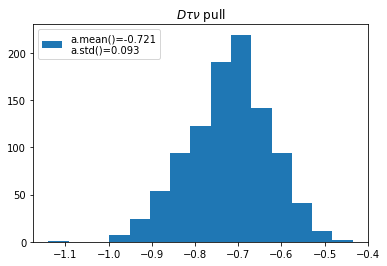

In [22]:
plt.hist(a, bins=15, label=f'''{a.mean()=:.3f}
{a.std()=:.3f}''')
plt.legend()
plt.title(r'$D\tau\nu$ pull')

Text(0.5, 1.0, '$D\\tau\\nu$ pull')

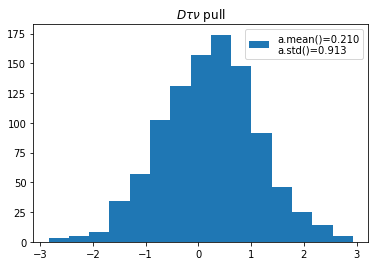

In [37]:
plt.hist(a, bins=15, label=f'''{a.mean()=:.3f}
{a.std()=:.3f}''')
plt.legend()
plt.title(r'$D\tau\nu$ pull')

Text(0.5, 1.0, '$D^\\ast\\tau\\nu$ pull')

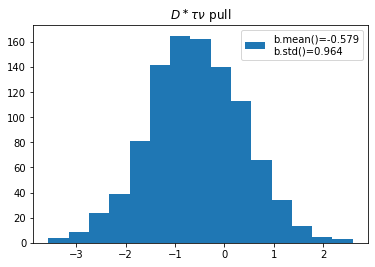

In [38]:
plt.hist(b,bins=15, label=f'''{b.mean()=:.3f}
{b.std()=:.3f}''')
plt.legend()
plt.title(r'$D^\ast\tau\nu$ pull')

In [70]:
with open('simple_asimov_test_1ab.json', 'w') as f:
    json.dump(template_test_set_1ab, f,sort_keys=True, indent=4)
with open('simple_asimov_test_3ab.json', 'w') as f:
    json.dump(template_test_set_3ab, f,sort_keys=True, indent=4)

# Create bootstrap samples with the same template sample

In [ ]:
# Load test samples
test = uproot.concatenate([f'../Samples/Generic_MC15ri/e_channel/BBbar_signal_region/{f}' for f in sample_lists[3:6]],
                          library="np",
                          cut=input_cut,
                          filter_branch=lambda branch: branch.name in columns)

df_test = pd.DataFrame(test)
# prepare containers for fit results
bootstrap_results = {'best_twice_nll':[],
                     'pval':[],
                     'best_fit':[],
                     'uncertainty':[]}
    
N_bootstraps = 500
bootstrap_fraction = 1
for i_bootstrap in range(N_bootstraps):

    rng = np.random.default_rng(seed=i_bootstrap)
    bootstrap_size = round( len(df_test)/N_bootstraps )
    bootstrapped_indeces = rng.choice(len(df_test), size=bootstrap_size, replace=False)
    df_test_bootstrapped = df_test.iloc[bootstrapped_indeces]

    (d_histogram, xedges, yedges) = np.histogram2d(df_test_bootstrapped['B0_CMS3_weMissM2'], 
                                                   df_test_bootstrapped['p_D_l'],
                                                   bins=[MM2_bins, p_D_l_bins],
                                                   weights=df_test_bootstrapped['__weight__'])
    d_histogram = d_histogram.T
    
    data_flat = d_histogram[indices_threshold].tolist()
    spec['observations'][0]['data']=data_flat
    
    ################### Load the model and perform a fit #############
    model, data = cabinetry.model_utils.model_and_data(spec)

    # fit the test sample
    pyhf.set_backend("jax", pyhf.optimize.minuit_optimizer(maxiter=1000000))
    fit_results = cabinetry.fit.fit(model=model, data=data)

    # store fit results
    bootstrap_results['best_twice_nll'].append(fit_results.best_twice_nll)
    bootstrap_results['pval'].append(fit_results.goodness_of_fit)
    bootstrap_results['best_fit'].append(fit_results.bestfit[:nFittingParameters].tolist())
    bootstrap_results['uncertainty'].append(fit_results.uncertainty[:nFittingParameters].tolist())

bootstrap_results['par_name']=model.config.par_names[:nFittingParameters]

In [33]:
a = (np.array(bootstrap_results['best_fit'])[:,0] - 0.002) / np.array(bootstrap_results['uncertainty'])[:,0]
# b = (np.array(bootstrap_results['best_fit'])[:,1] - 0.5) / np.array(bootstrap_results['uncertainty'])[:,1]

Text(0.5, 1.0, '$D\\tau\\nu$ pull')

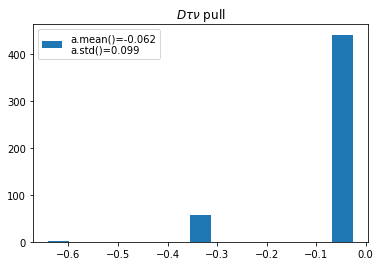

In [34]:
plt.hist(a, bins=15, label=f'''{a.mean()=:.3f}
{a.std()=:.3f}''')
plt.legend()
plt.title(r'$D\tau\nu$ pull')

# 3. Use independent small MC as tests

In [51]:
# Load test samples
test = uproot.concatenate([f'../Samples/Generic_MC15ri/e_channel/BBbar_signal_region/{f}' for f in sample_lists[:6]],
                          library="np",
                          cut=input_cut,
                          filter_branch=lambda branch: branch.name in columns)

df_test = pd.DataFrame(test).sample(frac=1, random_state=0)
# prepare containers for fit results
summary_results = {'best_twice_nll':[],
                     'pval':[],
                     'best_fit':[],
                     'uncertainty':[]}

num_subsets=50
all_test_classes=sample_classifier(df_test)

# Initialize an empty list to store the subsets
subsets = [[] for _ in range(num_subsets)]

# Split each DataFrame within the dictionary into 9 subsets
for key, df in all_test_classes.items():
    # Split the DataFrame into subsets
    df_subsets = np.array_split(df, num_subsets)

    # Append the subsets to the corresponding list in 'subsets'
    for i in range(num_subsets):
        subsets[i].append(df_subsets[i])

# Merge the corresponding subsets across keys
merged_subsets = [pd.concat(subset) for subset in subsets]
    
for df_test in merged_subsets:

    (d_histogram, xedges, yedges) = np.histogram2d(df_test['B0_CMS3_weMissM2'], 
                                                   df_test['p_D_l'],
                                                   bins=[MM2_bins, p_D_l_bins],
                                                   weights=df_test['__weight__'])
    d_histogram = d_histogram.T
    
    data_flat = d_histogram[indices_threshold].tolist()
    spec['observations'][0]['data']=data_flat
    
    ################### Load the model and perform a fit #############
    model, data = cabinetry.model_utils.model_and_data(spec)

    # fit the test sample
    pyhf.set_backend("jax", pyhf.optimize.minuit_optimizer(maxiter=1000000))
    fit_results = cabinetry.fit.fit(model=model, data=data)

    # store fit results
    summary_results['best_twice_nll'].append(fit_results.best_twice_nll)
    summary_results['pval'].append(fit_results.goodness_of_fit)
    summary_results['best_fit'].append(fit_results.bestfit[:nFittingParameters].tolist())
    summary_results['uncertainty'].append(fit_results.uncertainty[:nFittingParameters].tolist())

summary_results['par_name']=model.config.par_names[:nFittingParameters]

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 828                        │         Nfcn = 35, Ngrad = 6         │
│ EDM = 3.6e-07 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Be

DEBUG - cabinetry.fit - -2 log(L) = 871.007453 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm      =  0.0393 +/- 0.0050
INFO - cabinetry.fit - $D^\ast\tau\nu$_norm =  0.0406 +/- 0.0093
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 896.2                      │         Nfcn = 30, Ngrad = 4         │
│ EDM = 0.000108 (Goal: 0.0002)    │          

INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 830.5                      │         Nfcn = 34, Ngrad = 6         │
│ EDM = 4.86e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬────────────

DEBUG - cabinetry.fit - -2 log(L) = 852.274170 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm      =  0.0389 +/- 0.0052
INFO - cabinetry.fit - $D^\ast\tau\nu$_norm =  0.0407 +/- 0.0099
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 844.9                      │         Nfcn = 35, Ngrad = 6         │
│ EDM = 2.72e-07 (Goal: 0.0002)    │          

INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 834.6                      │         Nfcn = 35, Ngrad = 6         │
│ EDM = 3.52e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬────────────

DEBUG - cabinetry.fit - -2 log(L) = 835.533709 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm      =  0.0386 +/- 0.0056
INFO - cabinetry.fit - $D^\ast\tau\nu$_norm =  0.0425 +/- 0.0107
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 870.9                      │         Nfcn = 33, Ngrad = 5         │
│ EDM = 3.02e-05 (Goal: 0.0002)    │          

INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 812.8                      │         Nfcn = 32, Ngrad = 5         │
│ EDM = 1.05e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬────────────

DEBUG - cabinetry.fit - -2 log(L) = 869.419439 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm      =  0.0334 +/- 0.0056
INFO - cabinetry.fit - $D^\ast\tau\nu$_norm =  0.0515 +/- 0.0109
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 879.9                      │         Nfcn = 34, Ngrad = 6         │
│ EDM = 2.33e-07 (Goal: 0.0002)    │          

INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 843.4                      │         Nfcn = 32, Ngrad = 5         │
│ EDM = 4.63e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬────────────

DEBUG - cabinetry.fit - -2 log(L) = 865.896859 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - $D\tau\nu$_norm      =  0.0379 +/- 0.0053
INFO - cabinetry.fit - $D^\ast\tau\nu$_norm =  0.0435 +/- 0.0102


In [52]:
a = (np.array(summary_results['best_fit'])[:,0] - 0.04) / np.array(summary_results['uncertainty'])[:,0]
b = (np.array(summary_results['best_fit'])[:,1] - 0.04) / np.array(summary_results['uncertainty'])[:,1]

Text(0.5, 1.0, '$D\\tau\\nu$ pull')

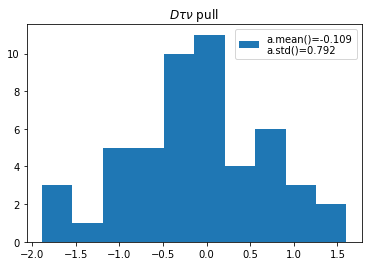

In [37]:
# 20 x 25
plt.hist(a, bins=10, label=f'''{a.mean()=:.3f}
{a.std()=:.3f}''')
plt.legend()
plt.title(r'$D\tau\nu$ pull')

Text(0.5, 1.0, '$D^\\ast\\tau\\nu$ pull')

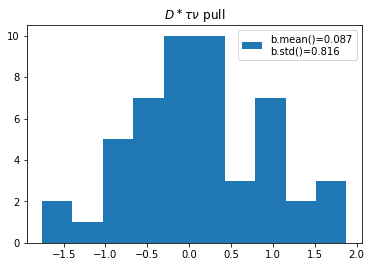

In [38]:
# 20 x 25
plt.hist(b,bins=10, label=f'''{b.mean()=:.3f}
{b.std()=:.3f}''')
plt.legend()
plt.title(r'$D^\ast\tau\nu$ pull')

Text(0.5, 1.0, '$D\\tau\\nu$ pull')

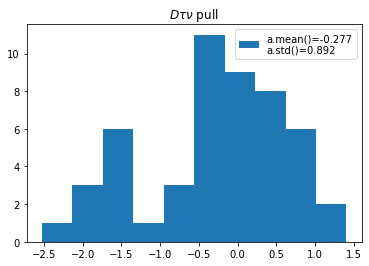

In [45]:
# 30 x 35
plt.hist(a, bins=10, label=f'''{a.mean()=:.3f}
{a.std()=:.3f}''')
plt.legend()
plt.title(r'$D\tau\nu$ pull')

Text(0.5, 1.0, '$D^\\ast\\tau\\nu$ pull')

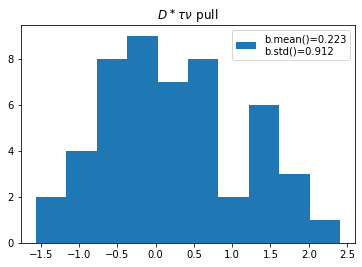

In [46]:
# 30 x 35
plt.hist(b,bins=10, label=f'''{b.mean()=:.3f}
{b.std()=:.3f}''')
plt.legend()
plt.title(r'$D^\ast\tau\nu$ pull')

Text(0.5, 1.0, '$D\\tau\\nu$ pull')

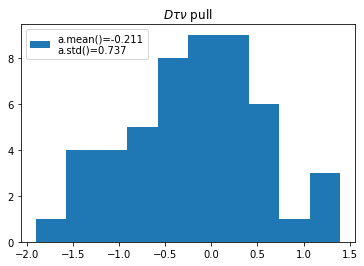

In [53]:
# 40 x 50
plt.hist(a, bins=10, label=f'''{a.mean()=:.3f}
{a.std()=:.3f}''')
plt.legend()
plt.title(r'$D\tau\nu$ pull')

Text(0.5, 1.0, '$D^\\ast\\tau\\nu$ pull')

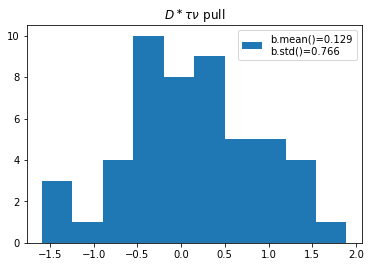

In [54]:
# 40 x 50
plt.hist(b,bins=10, label=f'''{b.mean()=:.3f}
{b.std()=:.3f}''')
plt.legend()
plt.title(r'$D^\ast\tau\nu$ pull')

Text(0.5, 1.0, '$D\\tau\\nu$ pull')

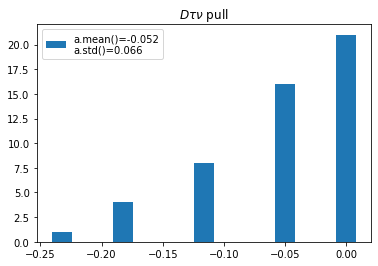

In [14]:
plt.hist(a, bins=15, label=f'''{a.mean()=:.3f}
{a.std()=:.3f}''')
plt.legend()
plt.title(r'$D\tau\nu$ pull')

Text(0.5, 1.0, '$D^\\ast\\tau\\nu$ pull')

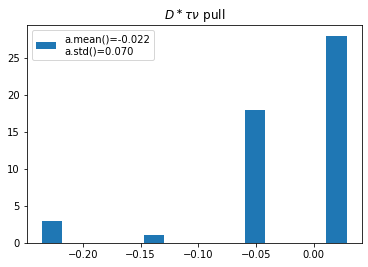

In [37]:
plt.hist(a,bins=15, label=f'''{a.mean()=:.3f}
{a.std()=:.3f}''')
plt.legend()
plt.title(r'$D^\ast\tau\nu$ pull')

Text(0.5, 1.0, '$D\\ell\\nu$ pull')

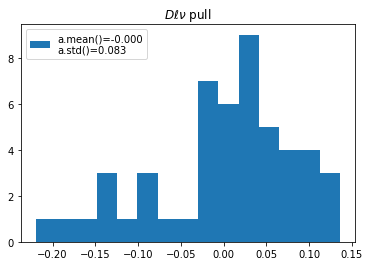

In [42]:
plt.hist(a,bins=15, label=f'''{a.mean()=:.3f}
{a.std()=:.3f}''')
plt.legend()
plt.title(r'$D\ell\nu$ pull')

Text(0.5, 1.0, '$D^\\ast\\ell\\nu$ pull')

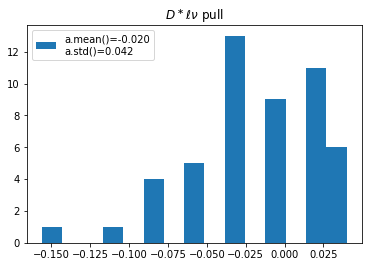

In [47]:
plt.hist(a,bins=15, label=f'''{a.mean()=:.3f}
{a.std()=:.3f}''')
plt.legend()
plt.title(r'$D^\ast\ell\nu$ pull')